Starting Inverse PINN Training...


Training Inverse PINN: 100%|██████████| 25000/25000 [00:19<00:00, 1269.86it/s]



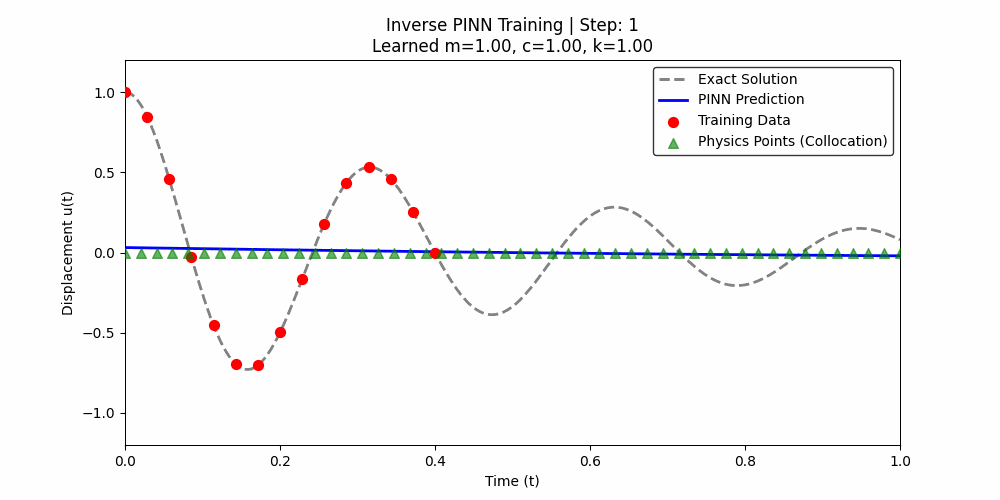


--- Inverse PINN Training Complete ---
True Parameters: m=1.0, c=4.0, k=400.0
Learned Parameters: m=0.0032, c=0.0141, k=1.2877

Plotting Parameter Convergence...


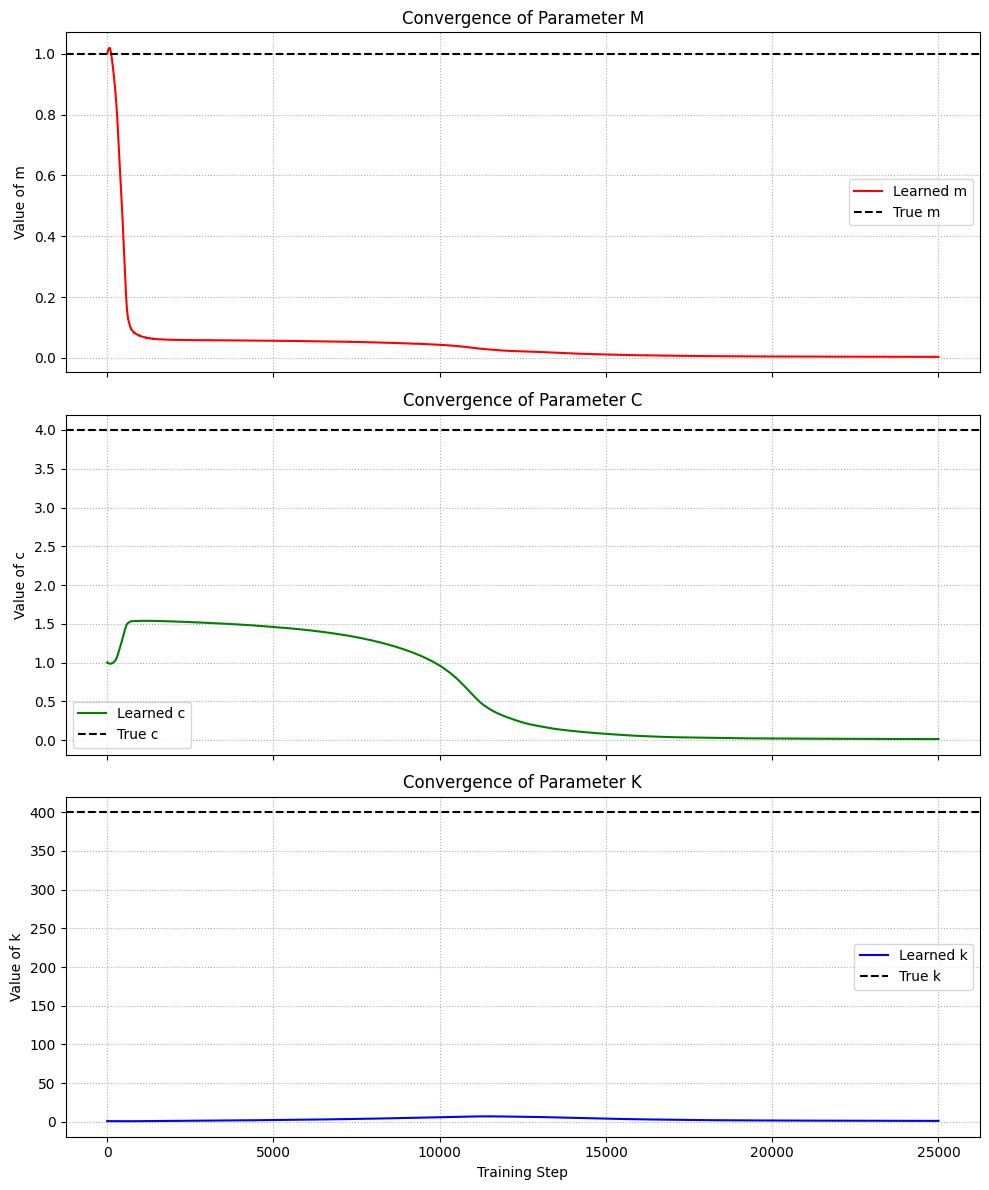

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import base64
from IPython.display import HTML, display
import imageio
from tqdm import tqdm

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

class HarmonicOscillator:
    """
    Defines the analytical solution for a standard underdamped harmonic oscillator.
    The governing equation is m*u'' + c*u' + k*u = 0.
    This is equivalent to u'' + (c/m)u' + (k/m)u = 0.
    Comparing with u'' + 2*d*u' + w0^2*u = 0, we have:
    d = c / (2*m)
    w0 = sqrt(k/m)
    """
    def __init__(self, m, c, k):
        self.m = m
        self.c = c
        self.k = k
        
        self.d = c / (2 * m)
        self.w0 = np.sqrt(k / m)
        
        assert self.d < self.w0, "System must be underdamped (c^2 < 4mk)"
        
        self.w = np.sqrt(self.w0**2 - self.d**2) 
        self.phi = np.arctan(-self.d / self.w) 
        self.A = 1 / (2 * np.cos(self.phi)) # Assuming initial condition u(0)=1, u'(0)=0
        
    def analytical_solution(self, t):
        cos_part = np.cos(self.phi + self.w * t)
        exp_part = np.exp(-self.d * t)
        u = exp_part * 2 * self.A * cos_part
        return u

    def generate_data(self, t_min_overall=0.0, t_max_overall=1.0, num_overall_points=500,
                      data_t_min=0.0, data_t_max=0.3607, num_data_points=10):
        t_full_domain = np.linspace(t_min_overall, t_max_overall, num_overall_points).reshape(-1, 1)
        u_full_solution = self.analytical_solution(t_full_domain).reshape(-1, 1)

        if data_t_min > data_t_max:
            data_t_min, data_t_max = data_t_max, data_t_min
        
        if data_t_min == data_t_max and num_data_points > 0:
            t_data = np.full((num_data_points, 1), data_t_min)
        elif num_data_points > 0:
             t_data = np.linspace(data_t_min, data_t_max, num_data_points).reshape(-1, 1)
        else:
            t_data = np.array([]).reshape(-1,1)

        u_data = self.analytical_solution(t_data).reshape(-1, 1) if t_data.size > 0 else np.array([]).reshape(-1,1)
            
        return t_full_domain, u_full_solution, t_data, u_data

class Visualizer:
    def __init__(self):
        plt.style.use('default')

    def plot_result(self, t, u_exact, t_data, u_data, u_pred, t_physics=None, iteration=None, learned_params=None):
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.grid(False)
        ax.plot(t, u_exact, color="gray", linewidth=2, linestyle='--', label="Exact Solution")
        ax.plot(t, u_pred, color="blue", linewidth=2, label="PINN Prediction")
        if t_data.size > 0:
            ax.scatter(t_data, u_data, color="red", s=50, label="Training Data", zorder=3)

        if t_physics is not None and len(t_physics) > 0:
             ax.scatter(t_physics, np.zeros_like(t_physics), 
                       color="green", s=50, label="Physics Points (Collocation)", marker="^", alpha=0.6, zorder=3)

        title = "Inverse PINN Training"
        if iteration is not None:
            title += f" | Step: {iteration+1}"
        if learned_params:
            m, c, k = learned_params['m'], learned_params['c'], learned_params['k']
            title += f"\nLearned m={m:.2f}, c={c:.2f}, k={k:.2f}"
        ax.set_title(title)
        
        ax.legend(frameon=True, facecolor='white', edgecolor='black')
        ax.set_xlabel("Time (t)")
        ax.set_ylabel("Displacement u(t)")
        ax.set_xlim([t.min(), t.max()])
        ax.set_ylim([-1.2, 1.2])
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        plt.close(fig)
        return image

    def create_animation(self, frames, filename='animation.gif'):
        if frames: 
            imageio.mimsave(filename, frames, fps=5, loop=0)
        else:
            print(f"No frames to create animation {filename}")

    def display_animation(self, filename='animation.gif'):
        try:
            with open(filename, 'rb') as f:
                data = f.read()
            data_url = "data:image/gif;base64," + base64.b64encode(data).decode()
            display(HTML(f'<img src="{data_url}">'))
        except (FileNotFoundError, NameError):
            print(f"Animation saved to {filename}. Display it manually if not in a Jupyter environment.")

class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

def inverse_pinn_loss(model, t_data, u_data, t_physics, m, c, k):
    # Data loss
    u_pred_data = model(t_data)
    loss_data = nn.MSELoss()(u_pred_data, u_data)

    # Physics loss
    t_physics_clone = t_physics.clone().detach().requires_grad_(True)
    u_physics = model(t_physics_clone)

    du_dt = torch.autograd.grad(u_physics, t_physics_clone, grad_outputs=torch.ones_like(u_physics), create_graph=True)[0]
    d2u_dt2 = torch.autograd.grad(du_dt, t_physics_clone, grad_outputs=torch.ones_like(du_dt), create_graph=True)[0]
    
    # The governing equation: m*u'' + c*u' + k*u = 0
    physics_residual = m * d2u_dt2 + c * du_dt + k * u_physics
    loss_physics = torch.mean(physics_residual ** 2) 
    lambda_physics = 1.0  # Weight for the physics loss term
    return loss_data + lambda_physics * loss_physics

def train_inverse_pinn(ho, visualizer,
                       t_min_overall, t_max_overall, num_overall_points,
                       data_t_min, data_t_max, num_data_points,
                       physics_t_min, physics_t_max, num_physics_points):
    print("Starting Inverse PINN Training...")
    t_domain_np, u_exact_solution_np, t_data_np, u_data_np = ho.generate_data(
        t_min_overall, t_max_overall, num_overall_points,
        data_t_min, data_t_max, num_data_points
    )

    t_physics_np = np.linspace(physics_t_min, physics_t_max, num_physics_points).reshape(-1, 1)

    layer_sizes = [1, 32, 32, 32, 1]
    model = NeuralNetwork(layer_sizes)

    # --- Key change for Inverse Problem: Define m, c, k as learnable parameters ---
    # Initialize with a guess (e.g., 1.0 for all)
    m_param = nn.Parameter(torch.tensor([1.0], dtype=torch.float32))
    c_param = nn.Parameter(torch.tensor([1.0], dtype=torch.float32))
    k_param = nn.Parameter(torch.tensor([1.0], dtype=torch.float32))

    t_data_tensor = torch.tensor(t_data_np, dtype=torch.float32)
    u_data_tensor = torch.tensor(u_data_np, dtype=torch.float32)
    t_full_domain_tensor = torch.tensor(t_domain_np, dtype=torch.float32)
    t_physics_tensor = torch.tensor(t_physics_np, dtype=torch.float32)
    
    # --- Key change: Add m, c, k to the optimizer ---
    optimizer = optim.Adam([
        {'params': model.parameters(), 'lr': 1e-3},
        {'params': [m_param, c_param, k_param], 'lr': 1e-3}
    ])

    num_steps = 25000
    frames = []
    param_history = {'m': [], 'c': [], 'k': []}

    for step in tqdm(range(num_steps), desc="Training Inverse PINN"):
        model.train()
        optimizer.zero_grad()
        
        loss = inverse_pinn_loss(model, t_data_tensor, u_data_tensor, t_physics_tensor, m_param, c_param, k_param)
        
        loss.backward()
        optimizer.step()

        # Store parameter history
        param_history['m'].append(m_param.item())
        param_history['c'].append(c_param.item())
        param_history['k'].append(k_param.item())

        if (step + 1) % 1500 == 0 or step == 0:
            model.eval()
            with torch.no_grad():
                u_pred_full_np = model(t_full_domain_tensor).numpy()
            
            current_params = {'m': m_param.item(), 'c': c_param.item(), 'k': k_param.item()}
            image = visualizer.plot_result(t_domain_np, u_exact_solution_np, t_data_np, u_data_np, 
                                           u_pred_full_np, t_physics=t_physics_np, iteration=step,
                                           learned_params=current_params)
            frames.append(image)

    visualizer.create_animation(frames, filename='oscillator_inverse_pinn.gif')
    visualizer.display_animation('oscillator_inverse_pinn.gif')
    
    print("\n--- Inverse PINN Training Complete ---")
    print(f"True Parameters: m={ho.m}, c={ho.c}, k={ho.k}")
    print(f"Learned Parameters: m={m_param.item():.4f}, c={c_param.item():.4f}, k={k_param.item():.4f}")
    
    model.eval()
    return model, param_history

def plot_parameter_convergence(param_history, true_params):
    print("\nPlotting Parameter Convergence...")
    fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    
    params = ['m', 'c', 'k']
    colors = ['red', 'green', 'blue']
    
    for i, param in enumerate(params):
        axs[i].plot(param_history[param], label=f'Learned {param}', color=colors[i])
        axs[i].axhline(y=true_params[param], linestyle='--', color='k', label=f'True {param}')
        axs[i].set_ylabel(f'Value of {param}')
        axs[i].legend()
        axs[i].grid(True, linestyle=':')
        axs[i].set_title(f'Convergence of Parameter {param.upper()}')

    axs[2].set_xlabel('Training Step')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # --- Configuration Variables ---
    # System parameters (the values we want the PINN to discover)
    TRUE_M = 1.0
    TRUE_C = 4.0  # Corresponds to original damping_coefficient d=2, since c = 2*d*m
    TRUE_K = 400.0 # Corresponds to original natural_frequency w0=20, since k = w0^2*m

    # Domain and Data Points
    OVERALL_T_MIN = 0.0
    OVERALL_T_MAX = 1.0
    NUM_OVERALL_POINTS = 500

    # Sparse measurements for training
    DATA_T_MIN = 0.0
    DATA_T_MAX = 0.4 
    NUM_DATA_POINTS = 15 # Using a few sparse points

    # Collocation points for enforcing physics
    PHYSICS_T_MIN = 0.0
    PHYSICS_T_MAX = 1.0
    NUM_PHYSICS_POINTS = 50
    # --- End Configuration ---

    # Initialize the harmonic oscillator with the TRUE parameters to generate data
    ho = HarmonicOscillator(m=TRUE_M, c=TRUE_C, k=TRUE_K)
    visualizer = Visualizer()

    # Train the inverse PINN to find m, c, and k
    inverse_model, history = train_inverse_pinn(
        ho, visualizer,
        OVERALL_T_MIN, OVERALL_T_MAX, NUM_OVERALL_POINTS,
        DATA_T_MIN, DATA_T_MAX, NUM_DATA_POINTS,
        PHYSICS_T_MIN, PHYSICS_T_MAX, NUM_PHYSICS_POINTS
    )

    # Plot the convergence of the learned parameters
    plot_parameter_convergence(history, {'m': TRUE_M, 'c': TRUE_C, 'k': TRUE_K})

Using device: cpu


Training: 100%|█████████████| 5000/5000 [01:47<00:00, 46.67it/s, loss=2.5790e-09, m=0.975, c=3.901, k=390.068]


--- Training Complete ---
True Parameters: m=1.00, c=4.00, k=400.00
Learned Parameters: m=0.9752, c=3.9006, k=390.0675


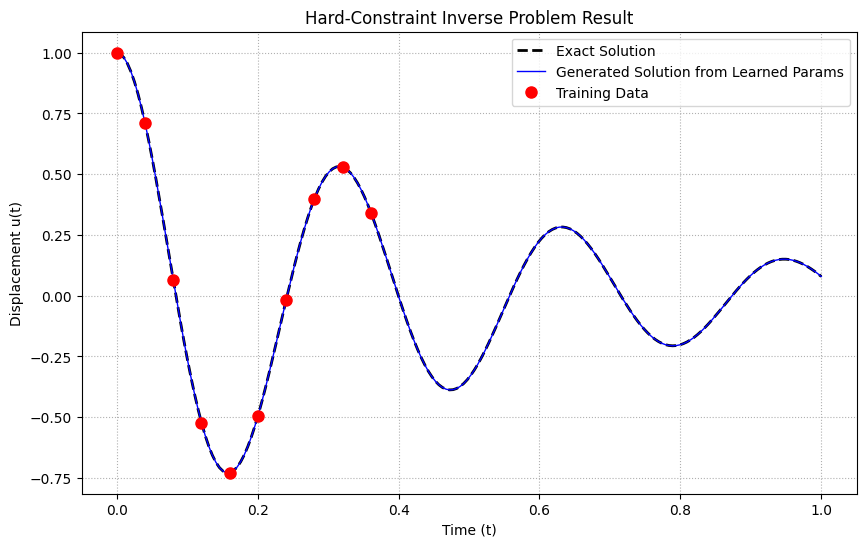

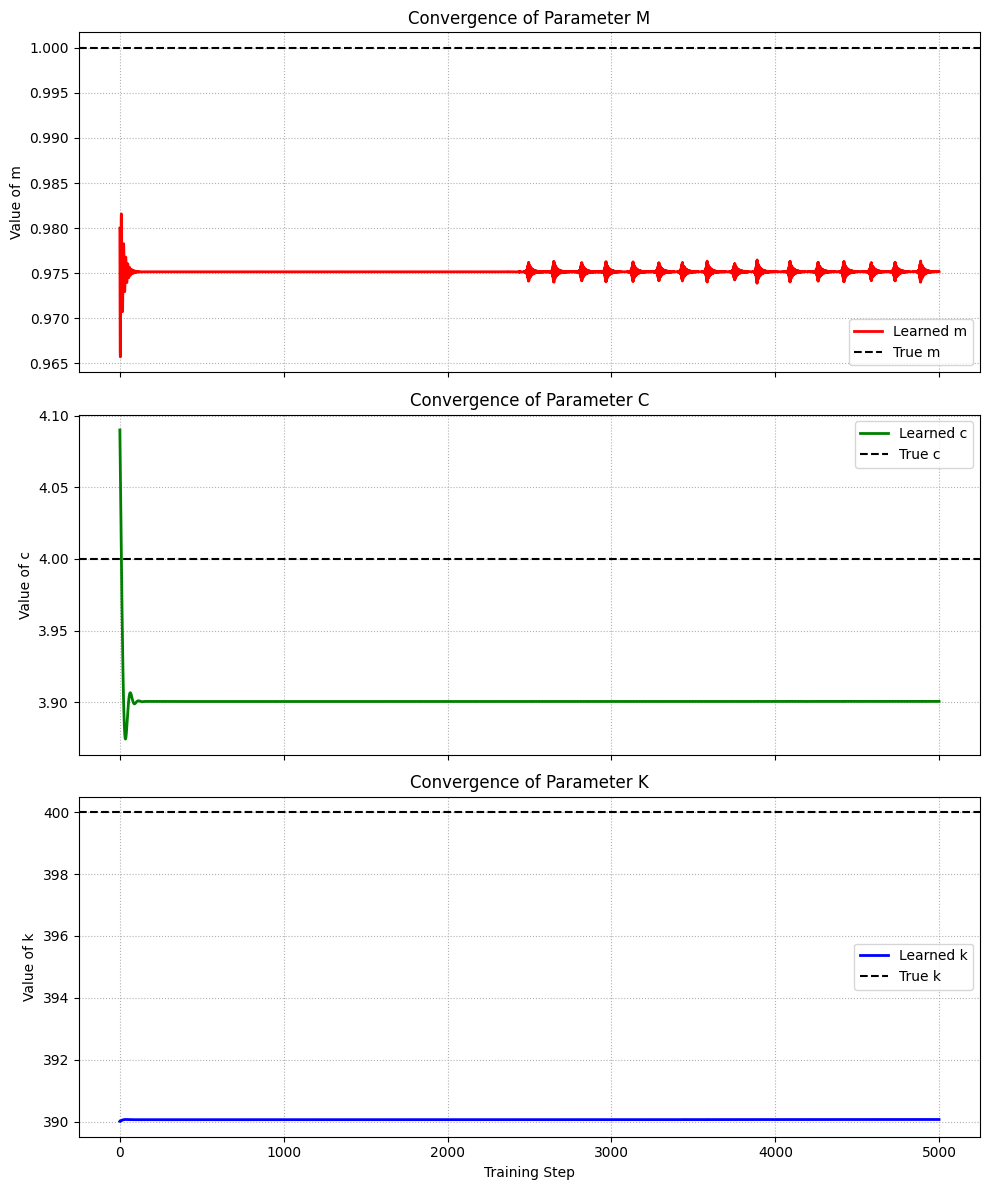

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchdiffeq import odeint

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- The ODE Definition ---
class ODEFunc:
    """
    Defines the system of first-order ODEs.
    y = [u, v] where v = u'
    dy/dt = [u', u''] = [v, -(c/m)v - (k/m)u]
    """
    def __init__(self, m, c, k):
        self.m = m
        self.c = c
        self.k = k

    def __call__(self, t, y):
        u, v = y[0], y[1]
        
        m_safe = self.m[0] + 1e-9 
        c_val = self.c[0]
        k_val = self.k[0]
        
        dudt = v
        dvdt = -(c_val / m_safe) * v - (k_val / m_safe) * u
        return torch.stack([dudt, dvdt])

# --- The Main Model ---
class HardConstraintInverseProblem(nn.Module):
    def __init__(self, initial_conditions):
        super(HardConstraintInverseProblem, self).__init__()
        
        self.initial_conditions = initial_conditions.to(device)
        
        # Learnable physical parameters, initialized with a reasonable guess
        self.m = nn.Parameter(torch.tensor([0.99], device=device)) # 1.0
        self.c = nn.Parameter(torch.tensor([4.1], device=device)) # 1.0
        self.k = nn.Parameter(torch.tensor([390.0], device=device)) # 100.0

    def forward(self, t_eval):
        """
        Generates the solution u(t) by solving the ODE with the current parameters.
        """
        ode_func = ODEFunc(self.m, self.c, self.k)
        
        solution = odeint(ode_func, self.initial_conditions, t_eval, method='dopri5', rtol=1e-5, atol=1e-7)
        
        return solution[:, 0].unsqueeze(1)

def analytical_solution(t, params):
    m, c, k = params['m'], params['c'], params['k']
    d = c / (2 * m)
    w0 = np.sqrt(k / m)
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    return np.exp(-d * t) * 2 * A * np.cos(phi + w * t)

def train_hard_constraint_model(config):
    # --- Data Generation ---
    t_data_np = np.linspace(config['data_domain'][0], config['data_domain'][1], config['data_points']).reshape(-1, 1)
    u_data_np = analytical_solution(t_data_np, config['true_params'])
    
    t_data = torch.tensor(t_data_np, dtype=torch.float32, device=device).flatten()
    u_data = torch.tensor(u_data_np, dtype=torch.float32, device=device)

    # --- Model and Optimizer ---
    initial_conditions = torch.tensor([1.0, 0.0], dtype=torch.float32) # u(0)=1, u'(0)=0
    model = HardConstraintInverseProblem(initial_conditions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    loss_fn = nn.MSELoss()

    history = {'loss': [], 'm': [], 'c': [], 'k': []}
    
    # --- Training Loop ---
    pbar = tqdm(range(config['steps']), desc='Training', ncols=110)
    for step in pbar:
        optimizer.zero_grad()
        
        u_pred = model(t_data)
        loss = loss_fn(u_pred, u_data)
        
        loss.backward()
        optimizer.step()

        history['loss'].append(loss.item())
        history['m'].append(model.m.item())
        history['c'].append(model.c.item())
        history['k'].append(model.k.item())
        
        if step % 100 == 0:
            pbar.set_postfix({
                'loss': f'{loss.item():.4e}',
                'm': f'{model.m.item():.3f}',
                'c': f'{model.c.item():.3f}',
                'k': f'{model.k.item():.3f}'
            })
            
    print("\n--- Training Complete ---")
    print(f"True Parameters: m={config['true_params']['m']:.2f}, c={config['true_params']['c']:.2f}, k={config['true_params']['k']:.2f}")
    print(f"Learned Parameters: m={model.m.item():.4f}, c={model.c.item():.4f}, k={model.k.item():.4f}")
    
    return model, history, t_data_np, u_data_np

def plot_results(model, history, config, t_data_np, u_data_np):
    plt.style.use('default')
    
    # Plot 1: Solution
    fig, ax1 = plt.subplots(figsize=(10, 6))
    t_plot_np = np.linspace(config['plot_domain'][0], config['plot_domain'][1], 200)
    u_exact = analytical_solution(t_plot_np, config['true_params'])
    
    model.eval()
    with torch.no_grad():
        t_plot_torch = torch.tensor(t_plot_np, dtype=torch.float32, device=device)
        u_pred = model(t_plot_torch).cpu().numpy()

    ax1.plot(t_plot_np, u_exact, 'k--', linewidth=2, label='Exact Solution')
    ax1.plot(t_plot_np, u_pred, 'b-', linewidth=1, label='Generated Solution from Learned Params')
    ax1.plot(t_data_np, u_data_np, 'ro', markersize=8, label='Training Data')
    ax1.set_xlabel('Time (t)')
    ax1.set_ylabel('Displacement u(t)')
    ax1.set_title('Hard-Constraint Inverse Problem Result')
    ax1.legend()
    ax1.grid(True, linestyle=':')
    plt.show()

    # Plot 2: Parameter Convergence
    fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    params = ['m', 'c', 'k']
    colors = ['red', 'green', 'blue']
    
    for i, param in enumerate(params):
        axs[i].plot(history[param], label=f'Learned {param}', color=colors[i], linewidth=2)
        axs[i].axhline(y=config['true_params'][param], linestyle='--', color='k', label=f'True {param}')
        axs[i].set_ylabel(f'Value of {param}')
        axs[i].legend()
        axs[i].grid(True, linestyle=':')
        axs[i].set_title(f'Convergence of Parameter {param.upper()}')

    axs[2].set_xlabel('Training Step')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    config = {
        'true_params': {'m': 1.0, 'c': 4.0, 'k': 400.0},
        'data_domain': (0.0, 0.3607),
        'data_points': 10,
        'plot_domain': (0.0, 1.0),
        'lr': 1e-2,
        'steps': 5000,
    }

    final_model, training_history, t_data, u_data = train_hard_constraint_model(config)
    plot_results(final_model, training_history, config, t_data, u_data)

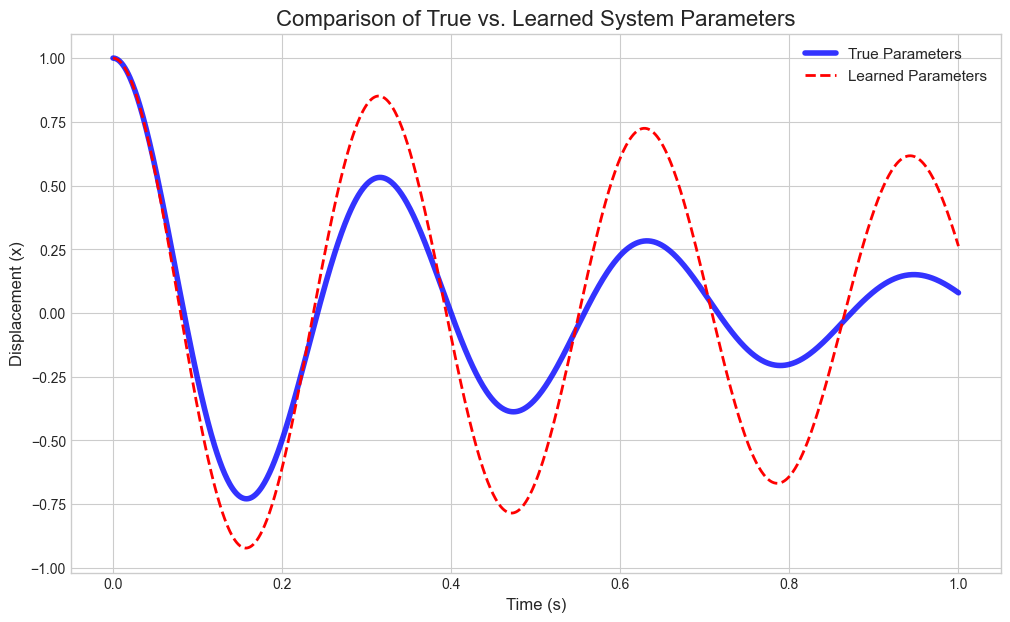

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def analytical_solution(t, params):
    """
    Calculates the analytical solution for a damped harmonic oscillator.
    This solution assumes initial conditions x(0)=1 and x'(0)=0.
    """
    m, c, k = params['m'], params['c'], params['k']
    
    # Damping term and natural frequency
    d = c / (2 * m)
    w0 = np.sqrt(k / m)
    
    # This solution is for underdamped systems (c^2 < 4mk)
    if d >= w0:
        # For this specific problem, both parameter sets are underdamped,
        # but this check is good practice.
        raise ValueError(f"System is critically damped or overdamped. Parameters: {params}")
        
    # Damped frequency
    w = np.sqrt(w0**2 - d**2)
    
    # Phase angle
    phi = np.arctan(-d / w)
    
    # Amplitude
    A = 1 / (2 * np.cos(phi))
    
    # Full solution
    return np.exp(-d * t) * 2 * A * np.cos(phi + w * t)

# 1. Define the two sets of parameters
true_params = {
    'm': 1.00, 
    'c': 4.00, 
    'k': 400.00
}

learned_params = {
    'm': 0.9752,
    'c': 3.9006, 
    'k': 390.0675
}

# 2. Create a time array for the plot
# Plot from t=0 to t=1 seconds to see the decay clearly
t = np.linspace(0, 1, 1000)

# 3. Calculate the displacement x(t) for both sets of parameters
x_t_true = analytical_solution(t, true_params)
x_t_learned = analytical_solution(t, learned_params)

# 4. Plot the results on the same axes
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

# Plot the 'True' curve
plt.plot(t, x_t_true, 'b-', label='True Parameters', linewidth=4, alpha=0.8)

# Plot the 'Learned' curve on top. It's a dashed line to show it overlaps.
plt.plot(t, x_t_learned, 'r--', label='Learned Parameters', linewidth=2)

# Add titles and labels for clarity
plt.title('Comparison of True vs. Learned System Parameters', fontsize=16)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Displacement (x)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True)

# Show the plot
plt.show()
